## 使用 多层感知器 对moons数据进行分类

In [1]:
import os
import numpy as np
from sklearn import metrics
from nnc import dataset as Data
from nnc.plot_tool import *

In [2]:
# 定义 激活函数
def linear(x,w,t):
    # 线性运算
    return np.dot(x,w)-t
def logistic(x):
    # Logistic 激活函数
    return 1.0 /(1.0 + np.exp(-x))
def logistic_grad(x):
    f = logistic(x)
    return np.multiply(f, (1.0 - f))

# 定义误差/损失函数
# 二分类问题 二值交叉熵损失函数
def BinaryCrossEntropyLoss(y,y_pred):
    # 二分类损失函数    
    if y.ndim <= 1:
        y = y.reshape(-1,1)
    if y_pred.ndim <= 1:
        y_pred = y_pred.reshape(-1,1)   
    num = y.shape[0]   # 样本数目
    loss = -1/num * (np.matmul(y.T,np.log(y_pred)) + np.matmul((1-y.T),np.log(1-y_pred)))
    return loss.squeeze()

def BinaryCrossEntropyLoss_grad(y,y_pred):
    # 计算损失函数对模型预测的导数
    if y.ndim <= 1:
        y = y.reshape(-1,1)
    if y_pred.ndim <= 1:
        y_pred = y_pred.reshape(-1,1)   
    num = y.shape[0]   # 样本数目
    grad = -1.0*(y/y_pred - (1-y)/(1-y_pred))/num
    return grad

# 分类问题评价指标
# 准确率 Accuracy
def accuracy(labels,preds):
    return metrics.accuracy_score(labels,preds)


### 带噪声的弯月形状数据 moon1000

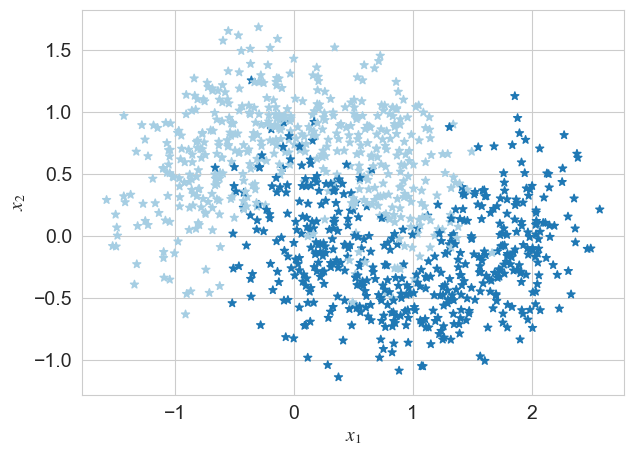

(400, 2)
(400, 1)


In [3]:
# 生成 moons 数据
Data.seed_random(2024) 
# (1) 数据集构建
# 随机采集1000个样本，并进行可视化。
n_samples = 1000    
train_percent = 0.40
test_percent = 0.60
noise = 0.3
# 生成数据
moons = Data.moons_data()
moons.gen_moons_data(n_samples,train_percent=train_percent,test_percent=test_percent,noise=noise)
# 训练数据集
train_dataset = (moons.train_data[0],moons.train_data[1])
# 测试数据集
test_dataset = (moons.test_data[0],moons.test_data[1])

# 绘制数据图像
fig_path = os.path.normpath('image/classification/moon_mlp/moon{}/fig/noise{}'.format(n_samples,noise))
data_type = 'all'  #  'train'    # 'test'  
moons.draw_data(fig_path, fig_name='moon-data-{}-n{}.pdf'.format(data_type,noise)) 

print(train_dataset[0].shape)
print(train_dataset[1].shape)


In [4]:
# 模型预测
def predict(X,param):  
    X = X.reshape(len(X),param['input_size'])
    # 计算模型输出
    z1 = linear(X,param['w1'],param['t1'])      # 隐层净输入向量
    y1 = logistic(z1)                           # 隐层的输出向量
    z2 = linear(y1,param['w2'],param['t2'])     # 输出层净输入向量
    y_pred = logistic(z2)                       # 输出层的输出向量
    return (y_pred >= 0.5).astype(np.int32)

# 模型评价
def evaluate(dataset,param):        
    X, y = dataset
    X = X.reshape(len(X),param['input_size'])
    y = y.reshape(len(y),param['output_size'])
    # 计算模型输出
    z1 = linear(X,param['w1'],param['t1'])      # 隐层净输入向量
    y1 = logistic(z1)                           # 隐层的输出向量
    z2 = linear(y1,param['w2'],param['t2'])     # 输出层净输入向量
    y_pred = logistic(z2)                       # 输出层的输出向量 
    loss = BinaryCrossEntropyLoss(y,y_pred)    
    # 准确率 Accuracy
    y_pred = (y_pred >= 0.5).astype(np.int32)
    score = accuracy(y,y_pred)
    return loss,score

# 样本训练 
# 2层前向神经网络结构，1-h-1
def mlp2_train(train_set,test_set,param,lr,epochs,eps,log_epochs=10):
    
    # 存放算法训练过程中的训练样本和测试样本误差
    loss = {}
    loss['train'] = []
    loss['test'] = []
    # 存放算法训练过程中的训练样本和测试样本 的分类正确率
    score = {}
    score['train'] = []
    score['test'] = []
    
    # train_set 训练数据(X,y)
    X,y = train_set
    X = X.reshape(len(X),param['input_size'])
    y = y.reshape(len(y),param['output_size'])
    N = X.shape[0]  # 样本数目
    
    # 使用梯度下降法
    for epoch in range(epochs):  # 训练轮数
        y_pred = np.zeros((N,1))    # 存放每个样本的实际输出
        for n in range(N):
            # 取出第n个样本输入网络进行权值更新
            xn = X[n].reshape(1,param['input_size'])
            # (1) 计算各层输出
            z1 = linear(xn,param['w1'],param['t1'])      # 隐层净输入向量
            y1 = logistic(z1)                              # 隐层的输出向量
            z2 = linear(y1,param['w2'],param['t2'])        # 输出层净输入向量
            y_pred[n] = logistic(z2)                       # 输出层的输出向量 （激活函数为恒等变换，保证取值范围合理）            
            # (2) 计算误差（损失）
            e = BinaryCrossEntropyLoss(y[n],y_pred[n])     # 交叉熵损失函数 
            # 二值交叉熵损失损失函数 关于输出y_pred的导数
            e_grad = BinaryCrossEntropyLoss_grad(y[n],y_pred[n]).reshape(1,param['output_size'])           
            # (3) 计算误差项(误差逐层反传)
            # 输出层激活函数（logistic）f(z) = z = y_pred(1-y_pred), 输出y_pred关于净输入z2的导数等于 
            e2 = np.multiply(- e_grad,logistic_grad(z2))
            e1 = np.multiply(logistic_grad(z1),np.matmul(e2,param['w2'].T))
            # (3) 权值和阈值修正
            param['w2'] = param['w2'] + lr* np.matmul(y1.T, e2)     # 权值修正
            param['t2'] = param['t2'] - lr* e2                      # 阈值修正
            param['w1'] = param['w1'] + lr* np.matmul(xn.T, e1)   # 权值修正
            param['t1'] = param['t1'] - lr* e1                      # 阈值修正
        # 一轮训练结束，计算训练误差
        train_loss = BinaryCrossEntropyLoss(y,y_pred)
        loss['train'].append(train_loss)
        y_pred = (y_pred >= 0.5).astype(np.int32)
        train_score = accuracy(y,y_pred)
        score['train'].append(train_score)
        
        # 对测试集进行评价        
        if test_set is not None:
            test_loss,test_score = evaluate(test_set,param)
            loss['test'].append(test_loss)
            score['test'].append(test_score)
        
        # 打印过程
        if log_epochs and epoch % log_epochs == 0:
            if test_set is None:
                np.set_printoptions(precision=4)
                print(f"[Train] epoch: {epoch}/{epochs}, train_loss: {np.around(train_loss,4)},train_score:{np.around(train_score,4)}")
            else:
                np.set_printoptions(precision=4)
                print(f"[Train/Test] epoch: {epoch}/{epochs}, train_loss/test_lost: ({np.around(train_loss,4)}/{np.around(test_loss,4)}), train_score/test_score:({np.around(train_score,4)}/{np.around(test_score,4)})")
        
        # 判断算法是否停止(评价模型)
        if train_loss < eps or epoch == epochs-1:  
            print('\n 训练结束: ')
            if train_loss < eps:
                print(f' - 算法迭代次数: {epoch+1}')
            else:
                print(f' - 算法迭代次数: {epoch}')
            return loss,score,param


开始训练 ......
[Train/Test] epoch: 0/1000, train_loss/test_lost: (0.4237/0.3576), train_score/test_score:(0.8225/0.8367)
[Train/Test] epoch: 25/1000, train_loss/test_lost: (0.3592/0.3424), train_score/test_score:(0.8525/0.8383)
[Train/Test] epoch: 50/1000, train_loss/test_lost: (0.2857/0.2587), train_score/test_score:(0.89/0.8817)
[Train/Test] epoch: 75/1000, train_loss/test_lost: (0.2612/0.2174), train_score/test_score:(0.9/0.9067)
[Train/Test] epoch: 100/1000, train_loss/test_lost: (0.2567/0.2276), train_score/test_score:(0.9025/0.9083)
[Train/Test] epoch: 125/1000, train_loss/test_lost: (0.252/0.226), train_score/test_score:(0.915/0.9083)
[Train/Test] epoch: 150/1000, train_loss/test_lost: (0.2486/0.2279), train_score/test_score:(0.915/0.905)
[Train/Test] epoch: 175/1000, train_loss/test_lost: (0.2478/0.2263), train_score/test_score:(0.915/0.905)
[Train/Test] epoch: 200/1000, train_loss/test_lost: (0.2465/0.2224), train_score/test_score:(0.915/0.9067)
[Train/Test] epoch: 225/1000, trai

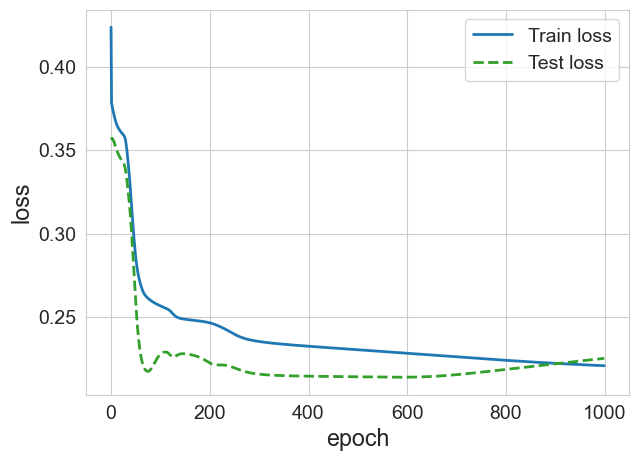

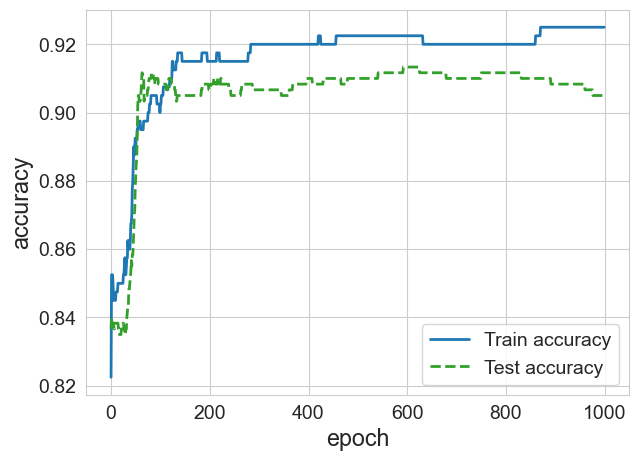

In [5]:
# mlp  1-3-1
param = {}        # 网络参数
input_size = 2    # 输入层节点数目
hidden_size = 6   # 隐层神经元数目
output_size = 1   # 输出层神经元数目
param['input_size'] = input_size
param['hidden_size'] = hidden_size
param['output_size'] = output_size

# 设置初始权值和阈值
param['w1'] = np.random.randn(input_size,hidden_size)   # 隐层权值        # 默认"标准正态分布初始化"  
param['t1'] = np.zeros((1,hidden_size))                 # 隐层阈值        # 默认 0
param['w2'] = np.random.randn(hidden_size,output_size)  # 输出层权值
param['t2'] = np.zeros((1,output_size))                 # 输出层阈值

# 设置算法参数
lr = 0.2                                    # 学习率
epochs = 1000                                # 最大训练轮数
eps = 1e-4                                     # 训练停止精度要求
log_epochs = 25

print("====================================================================")
print("开始训练 ......")
# 训练模型
loss,score,param = mlp2_train(train_dataset,test_dataset,param,lr,epochs,eps,log_epochs=log_epochs)

#fig_path = os.path.normpath(f'image/classification/moon_mlp/fig/noise{noise}')
fig_path = os.path.normpath(os.path.join(fig_path,f"h{hidden_size}_o{output_size}_lr{lr}"))
# (3) 可视化 --- 观察训练集与验证集的指标变化情况  
# (3.1) 绘制训练\测试 损失变化曲线
fig_name = 'train-test-{}.pdf' 
param_name = 'epoch'    
metric_name =  'loss' 
train_results = (loss['train'],[])
test_results = (loss['test'],[])
draw_scores(fig_path,fig_name.format(metric_name),train_scores=train_results,
                      test_scores=test_results,metric=metric_name,param_name=param_name)
# (3.2) 绘制训练\测试 分类正确率变化曲线
fig_name = 'train-test-{}.pdf' 
param_name = 'epoch'    
metric_name =  'accuracy' 
train_results = (score['train'],[])
test_results = (score['test'],[])
draw_scores(fig_path,fig_name.format(metric_name),train_scores=train_results,
                      test_scores=test_results,metric=metric_name,param_name=param_name)
